# CloudSeg: Training & Visualization

This notebook will train your `SimpleSegModel` on the SWINySEG data and visualize:

- A sample image & mask
- Training vs. validation loss curves
- IoU metric per epoch
- A metrics table and its correlation matrix
- Side-by-side sample predictions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from src.data_loader import get_simple_loaders
from src.model import SimpleSegModel

import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Hyperparameters
BATCH_SIZE = 4
IMG_SIZE   = (256, 256)
LR         = 1e-3
MAX_EPOCHS = 20

# Create loaders (train & val)
train_loader = get_simple_loaders(
    images_dir="data/raw/images",
    masks_dir="data/raw/masks",
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    normalize=True,
    shuffle=True
)
val_loader = get_simple_loaders(
    images_dir="data/raw/images",
    masks_dir="data/raw/masks",
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    normalize=True,
    shuffle=False
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.6051416].


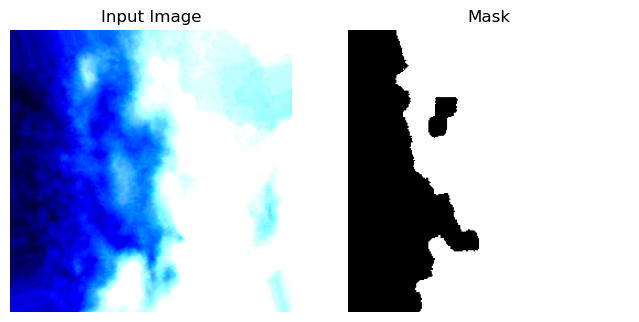

In [3]:
imgs, masks = next(iter(train_loader))

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(imgs[0].permute(1,2,0))
axes[0].set_title("Input Image")
axes[0].axis("off")
axes[1].imshow(masks[0,0], cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
plt.show()


In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Running on:", device)

model     = SimpleSegModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Early‐stop settings
MAX_EPOCHS        = 50
PATIENCE          = 5
best_val_loss     = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses   = []
val_ious     = []

for epoch in range(1, MAX_EPOCHS+1):
    # ── Training ──
    model.train()
    running_train_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader)
    
    # ── Validation ──
    model.eval()
    running_val_loss = 0.0
    intersection, union = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            running_val_loss += criterion(outputs, masks).item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection += (preds * masks).sum().item()
            union        += (preds + masks).sum().item() - (preds * masks).sum().item()
    val_loss = running_val_loss / len(val_loader)
    val_iou  = (intersection + 1e-6) / (union + 1e-6)
    
    # ── Early stopping check ──
    if val_loss < best_val_loss:
        best_val_loss     = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"No improvement in {PATIENCE} epochs—stopping at epoch {epoch}.")
            break

    # ── Record & print ──
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    print(f"Epoch {epoch}/{MAX_EPOCHS} — "
          f"train_loss: {train_loss:.4f}, "
          f"val_loss: {val_loss:.4f}, "
          f"val_iou: {val_iou:.4f}")

Running on: cuda:0
Epoch 1/50 — train_loss: 0.3206, val_loss: 0.3194, val_iou: 0.7817
Epoch 2/50 — train_loss: 0.2847, val_loss: 0.2844, val_iou: 0.7807
Epoch 3/50 — train_loss: 0.2732, val_loss: 0.2680, val_iou: 0.8096
Epoch 4/50 — train_loss: 0.2688, val_loss: 0.3071, val_iou: 0.7922
Epoch 5/50 — train_loss: 0.2686, val_loss: 0.2639, val_iou: 0.8057
Epoch 6/50 — train_loss: 0.2679, val_loss: 0.2740, val_iou: 0.8054
Epoch 7/50 — train_loss: 0.2662, val_loss: 0.2744, val_iou: 0.7934
Epoch 8/50 — train_loss: 0.2665, val_loss: 0.2631, val_iou: 0.8084
Epoch 9/50 — train_loss: 0.2652, val_loss: 0.2613, val_iou: 0.8116
Epoch 10/50 — train_loss: 0.2642, val_loss: 0.2583, val_iou: 0.8118
Epoch 11/50 — train_loss: 0.2637, val_loss: 0.2611, val_iou: 0.8115
Epoch 12/50 — train_loss: 0.2627, val_loss: 0.2611, val_iou: 0.8069
Epoch 13/50 — train_loss: 0.2625, val_loss: 0.2698, val_iou: 0.8058
Epoch 14/50 — train_loss: 0.2615, val_loss: 0.2572, val_iou: 0.8141
Epoch 15/50 — train_loss: 0.2612, val_

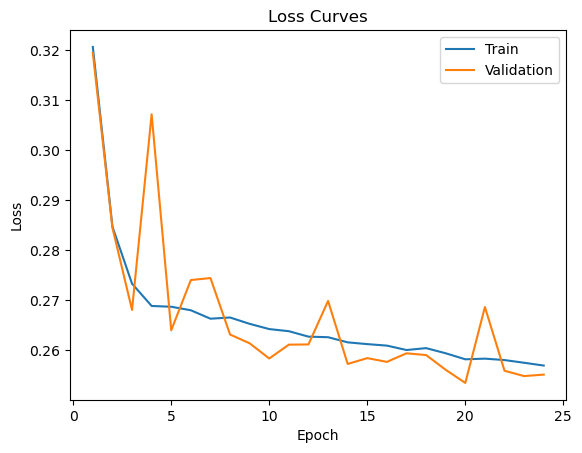

In [6]:
# Compute the actual epoch indices
epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses,   label="Validation")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [8]:
# Determine how many epochs actually ran
num_epochs = len(train_losses)

# Build the DataFrame
metrics_df = pd.DataFrame({
    "epoch":      list(range(1, num_epochs+1)),
    "train_loss": train_losses,
    "val_loss":   val_losses,
    "val_iou":    val_ious
}).set_index("epoch")

metrics_df



,train_loss,val_loss,val_iou
epoch,,,
1,0.320583,0.319374,0.781748
2,0.284653,0.284438,0.780741
3,0.273248,0.268008,0.809555
4,0.268792,0.307110,0.792179
5,0.268639,0.263934,0.805699
6,0.267934,0.273974,0.805427
7,0.266247,0.274376,0.793371
8,0.266488,0.263081,0.808418
9,0.265217,0.261329,0.811591


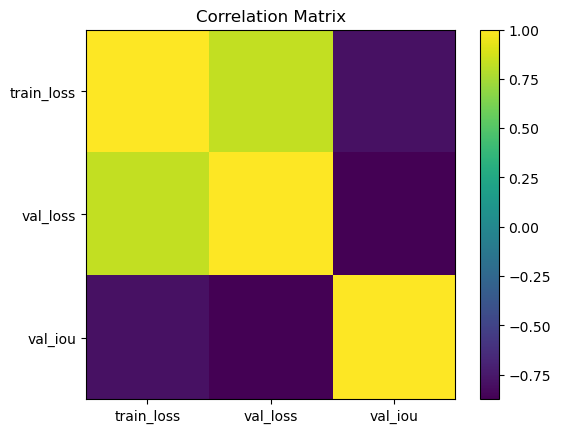

In [9]:
corr = metrics_df.corr()
plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Matrix")
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0904187..1.8731157].


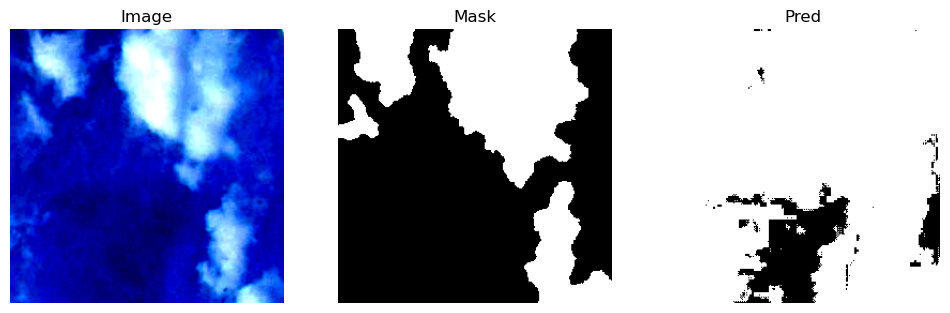

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].


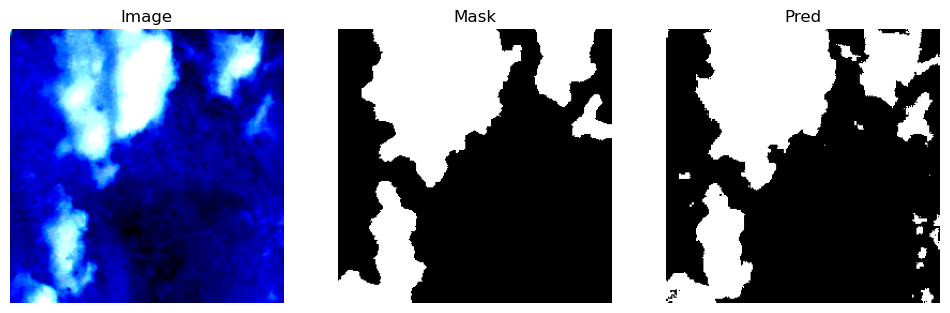

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


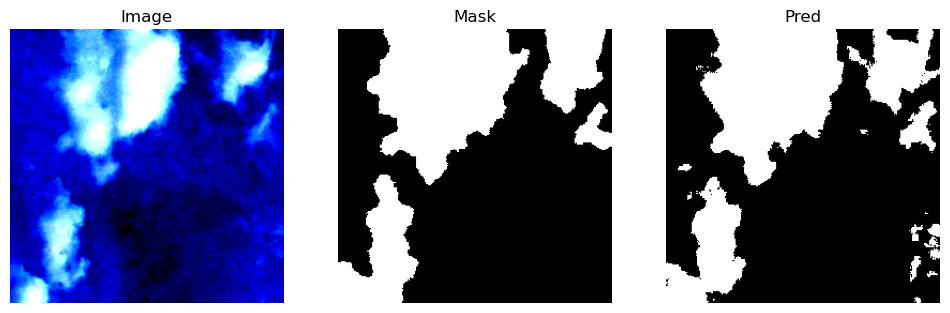

In [10]:
# Grab a few from the val set
imgs, masks = next(iter(val_loader))
outputs     = model(imgs.to(device)).cpu()
preds       = (torch.sigmoid(outputs) > 0.5).float()

for i in range(3):
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(imgs[i].permute(1,2,0)); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(masks[i,0], cmap="gray");        axes[1].set_title("Mask");  axes[1].axis("off")
    axes[2].imshow(preds[i,0], cmap="gray");        axes[2].set_title("Pred");  axes[2].axis("off")
    plt.show()
